In [1]:
push!(LOAD_PATH, pwd()*"/..")
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase


Use "Dict(a=>b for (a,b) in c)" instead.


In [2]:
c_r = 0.3
N = 400
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n

k = 10
sigma_k = 15
min_degree = 3

# k_range = get_k_range(N) 

# degr_distr = mock_degree_distribution(k,sigma_k)

degr_distr = get_p_k_two_degree(compute_two_degree_params(k,sigma_k,min_degree))
# degr_distr = get_p_k_gamma(sigma_k,k,min_degree)
p_k,p_k_neighbor,mean_k = get_p_k_as_vec(degr_distr,N)
# degree_distribution(x) = degr_distr(x) #(x) = 1/N
# mean_k = get_mean_k(degree_distribution,N)
# neighbor_degree_distribution(x) = neighbor_degree_distribution(x,degree_distribution,mean_k)
# p_k = []
# p_k_neighbor = []
# for x in k_range
#     push!(p_k,degree_distribution(x))
#     push!(p_k_neighbor,neighbor_degree_distribution(x))
# end
# p_k /= sum(p_k)
# p_k_neighbor /= sum(p_k_neighbor)
mean_k

10.0

In [3]:
y_desired_range = logspace(log10(1/N),log10(1),10) 
delta_y_plus = similar(y_desired_range)
delta_y_minus = similar(y_desired_range)
y_bar = similar(y_desired_range)
gammas = similar(y_desired_range)
y_local = similar(y_desired_range)
for (i,y_desired) in enumerate(y_desired_range)
    println(i)
#     if i == 1
#         y_k = y_desired*ones(N)
#     else
#       y_k = y_desired*ones(N)
      y_k = get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
#     y_k = get_y_k_branching_process(y_desired,p_k,alpha,N)#get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
#     end
#     y_k /= 2.0
    mean_y_k = get_mean_y_k(y_k,p_k_neighbor,N)
    
    y_local[i] = mean_y_k
    gammas[i] = y_k[end]
    y_bar[i] = get_y_bar(p_k,y_k) 
    delta_y_plus[i] = get_delta_y_plus(y_k,p_k,mean_y_k,N,alpha)
    delta_y_minus[i] = get_delta_y_minus(y_k,p_k,mean_y_k,N,beta)
end

1
2
3
4
5
6
7
8
9
10


In [4]:
using Dierckx
function get_p_reach_from_delta_y(delta_y_plus,delta_y_minus)
    s = delta_y_plus - delta_y_minus
    splus = delta_y_plus + delta_y_minus
    
    interpolation_order = 3
    s_fn(x) = evaluate(Spline1D(y_desired_range,s,k=interpolation_order,bc="extrapolate"),x)
    splus_fn(x) = evaluate(Spline1D(y_desired_range,splus,k=interpolation_order,bc="extrapolate"),x)
    
    dx = 1/N
    yy = collect(1/N:dx:1)
    pp = P_reach_fast(s_fn,splus_fn,N,1.0/N,yy)
end

get_p_reach_from_delta_y (generic function with 1 method)

In [15]:
y_desired_range = logspace(log10(1/N),0,10)
y_1_range = zeros(y_desired_range)
y_2_range = zeros(y_desired_range)
for (i,y_desired_curr) in enumerate(y_desired_range)
    y_k_curr = get_y_k_equilibrium(y_desired_curr,N,p_k,p_k_neighbor,alpha,beta)[1:end-1]
    y_k_curr = y_k_curr[p_k .> 0]
    y_1_range[i] = y_k_curr[1]
    y_2_range[i] = y_k_curr[2]
end

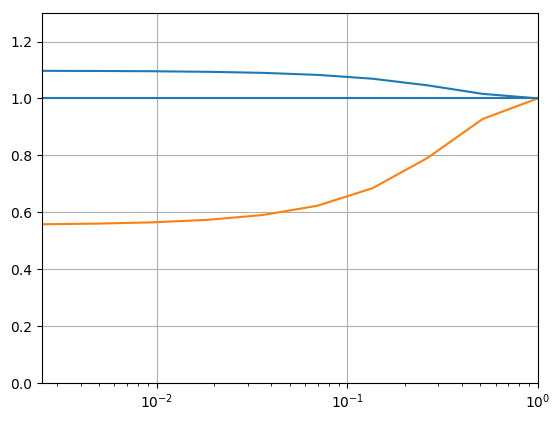

In [16]:
semilogx(y_desired_range,y_1_range./y_desired_range)
semilogx(y_desired_range,y_2_range./y_desired_range)
ylim([0.0,1.3])
xlim([1/N,1])
axhline(1.0)
grid()

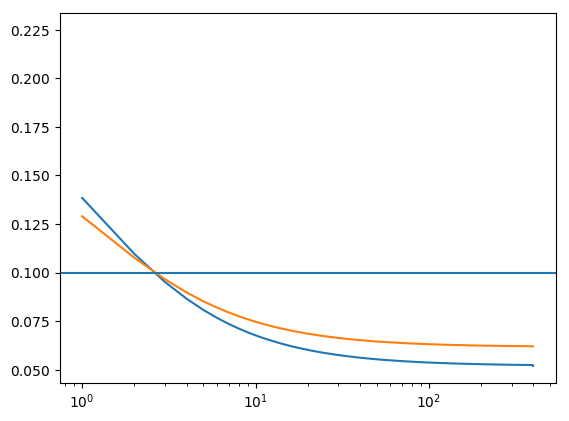

PyObject <matplotlib.lines.Line2D object at 0x321d08910>

In [17]:
y_desired_curr = 0.1
y_k_curr = get_y_k_equilibrium(y_desired_curr,N,p_k,p_k_neighbor,alpha,beta)[1:end-1]
semilogx(get_y_k_branching_process(y_desired_curr,p_k,alpha,N))
semilogx(y_k_curr)
# println(y_k_curr[p_k .> 0]./y_desired_curr)
# semilogx(y_desired_range,y_k)

axhline(0.1)

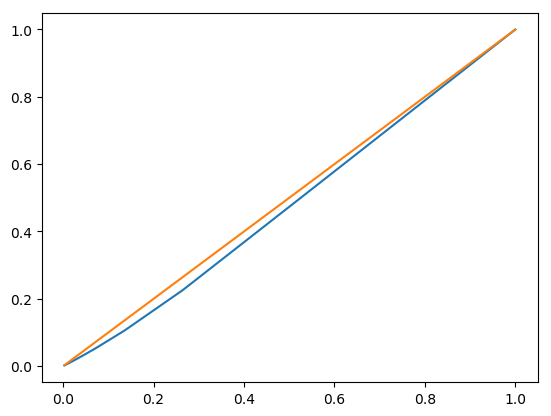

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328bc4c50>

In [18]:
plot(y_desired_range,y_local)
plot(y_desired_range,y_bar)

In [19]:
s = delta_y_plus - delta_y_minus
splus = delta_y_plus + delta_y_minus
# plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)))
# # plot(y_desired_range,s1./(y_desired_range.*(1 - y_desired_range)))
# plot(y_desired_range,alpha*y_desired_range - beta)
# plot(y_desired_range,get_s_eff_exact(y_desired_range,alpha,beta,k,N))
# # plot(y_desired_range,get_s_eff_degree_distribution_gamma(y_desired_range,alpha,beta,k,sigma_k,N))
# plot(y_desired_range,get_s_eff_degree_distribution(y_desired_range,alpha,beta,degree_distribution,N))

10-element Array{Float64,1}:
  0.00664832 
  0.0129385  
  0.0251827  
  0.0490227  
  0.09545    
  0.185796   
  0.360277   
  0.680468   
  1.08444    
 -4.68761e-16

In [20]:
using Dierckx
interpolation_order = 3
s_fn(x) = evaluate(Spline1D(y_desired_range,s,k=interpolation_order,bc="extrapolate"),x)
splus_fn(x) = evaluate(Spline1D(y_desired_range,splus,k=interpolation_order,bc="extrapolate"),x)


splus_fn (generic function with 1 method)

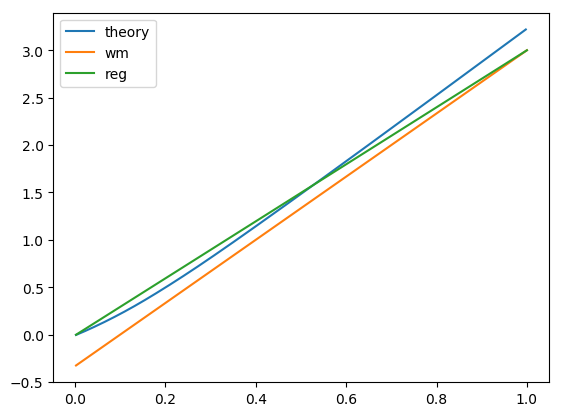

PyObject <matplotlib.legend.Legend object at 0x328bf5c90>

In [21]:

dx = 1/N
yy = collect(1/N:dx:1)
plot(yy,s_fn(yy)./(yy.*(1 - yy)),label="theory")
# plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)),"o")
plot(yy,alpha*yy - beta,label="wm")
plot(yy,get_s_eff_exact(yy,alpha,beta,k,N),label="reg")
# plot(yy,get_s_eff_degree_distribution(yy,alpha,beta,degree_distribution,N),label="naive theory")
legend(loc="best")

In [22]:
pp = P_reach_fast(s_fn,splus_fn,N,1.0/N,yy)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
pp_regular = P_reach_fast(im,N,1.0/N,yy,true)
im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta);
pp_naive = P_reach_fast(im,N,1.0/N,yy,true)



400-element Array{Float64,1}:
 1.0     
 0.560346
 0.416992
 0.347701
 0.307946
 0.282916
 0.266232
 0.254656
 0.246449
 0.240557
 0.236203
 0.233054
 0.23068 
 ⋮       
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943
 0.223943

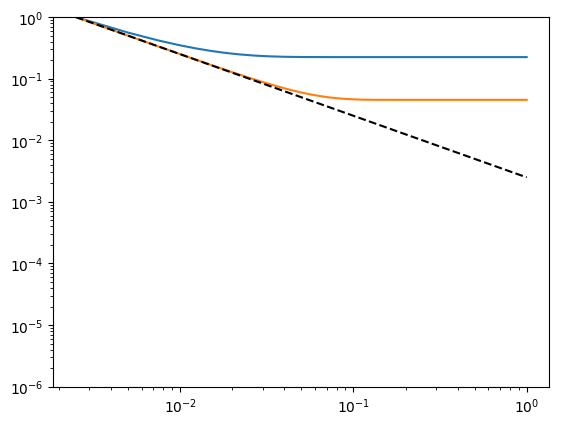

/Users/julian/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(1.0e-6,1.0)

In [23]:
# loglog(yy,pp_regular)
loglog(yy,pp_naive)
# loglog(yy,pp_test)
loglog(yy,pp)
# plot(yy,pp1,label="intermediate")
# plot(yy,pp2,label="equal y_k")
# plot(yy,pp3,label="newest")
# plot(yy,pp4,label="newest")
plot(yy,1./(N*yy),"--k")
legend()
# plot(yy,log(N*yy))
# xlim([0,0.01])
ylim([1e-6,1e0])

## Sampling the node distribution and the infecteds

In [24]:
function get_s(k_tilde,k_bar,y_0)
    y_tilde = y_0*k_tilde/k_bar 
    a = (1 - y_0)*y_tilde - (1 - y_tilde)*y_0*(1 + beta)
    b = 1/N*((1 - y_0)*y_tilde + (1 - y_tilde)*y_0*(1 + beta))
    s = 2*a/(N*b)
end

function get_a(k_tilde,k_bar,y_0)
    y_tilde = y_0*k_tilde/k_bar 
    a = (1 - y_0)*y_tilde - (1 - y_tilde)*y_0*(1 + beta)
    return a
end
    
function get_b(k_tilde,k_bar,y_0)
    y_tilde = y_0*k_tilde/k_bar 
    b = 1/N*((1 - y_0)*y_tilde + (1 - y_tilde)*y_0*(1 + beta))
    return b
end

get_b (generic function with 1 method)

In [25]:
function sample_n_k_distribution(n,N,p_k,y_k)
    ks = collect(1:N-1)
    samp = zeros(ks)
    d = Multinomial(N,p_k)
    N_k = rand(d)
    for i = 1:n
        weight_vec = 1/N*N_k.*y_k
        k_curr = sample(ks,WeightVec(weight_vec))
        N_k[k_curr] -= 1
        samp[k_curr] += 1
    end
    samp
end

sample_n_k_distribution (generic function with 1 method)

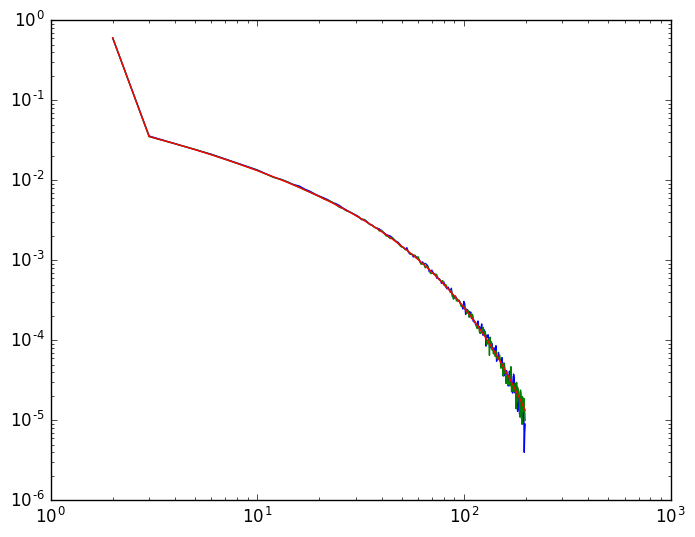

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x334808090>

In [256]:
n = 100
arr = 1.0*zeros(N-1)
arr1 = 1.0*zeros(N-1)
y_k = get_y_k_equilibrium(n/N,N,p_k,p_k_neighbor,alpha,beta)[1:end-1]
y_k /= sum(y_k)
d = Multinomial(n,y_k.*p_k/sum(y_k.*p_k))
num_samples = 10000
for i = 1:num_samples
    arr += sample_n_k_distribution(n,N,p_k,y_k)
    arr1 += rand(d)
end
loglog(arr/sum(arr))
loglog(arr1/sum(arr1))
plot(p_k.*y_k./sum(p_k.*y_k))

In [26]:
using Distributions 
using StatsBase
function get_s_mc(n,N,k_bar,p_k,y_k,alpha,beta,num_samples = 100;replacement=true)
    z_k = p_k .* y_k
    z_k /= sum(z_k)
    y_k /= sum(y_k)
    y = n/N
    d = Multinomial(n,z_k)
    k_vec = collect(1:N-1)
    a_accum = 0
    b_accum = 0
    s_accum = 0
    for i = 1:num_samples
        if replacement
            n_k_sample = rand(d)
        else
            n_k_sample = sample_n_k_distribution(n,N,p_k,y_k)
        end
#         println(n_k_sample)
        y_tilde_vec = dot(k_vec,n_k_sample)/(N*k_bar) * ones(Float64,k_vec)
        y_tilde_sq_vec = y_tilde_vec.*(y_tilde_vec + (1 - y_tilde_vec).*(N - k_vec)./(N*k_vec))
#         println(y_tilde_sq_vec)
        a_curr = dot(p_k,get_a_y_y_tilde(y,y_tilde_vec,y_tilde_sq_vec,alpha,beta) )
        b_curr = dot(p_k,get_b_y_y_tilde(y,y_tilde_vec,y_tilde_sq_vec,alpha,beta,N) )
        s_curr = get_s_from_a_b(a_curr,b_curr,N)
        a_accum += a_curr
        b_accum += b_curr
        s_accum += s_curr
    end
    a_accum /= num_samples
    b_accum /= num_samples
    s_accum /= num_samples
    
    s_pre_ave = s_accum
    s_post_ave = get_s_from_a_b(a_accum,b_accum,N)
    
    return s_pre_ave, s_post_ave, a_accum, b_accum
end
    
function get_s_from_a_b(a,b,N)
    return 2*a/(N*b)
end

function get_a_y_y_tilde(y,y_tilde,beta)
    return (1 - y)*y_tilde - (1 - y_tilde)*y*(1 + beta)
end
    
function get_b_y_y_tilde(y,y_tilde,beta,N)
    return 1/N*((1 - y)*y_tilde + (1 - y_tilde)*y*(1 + beta))
end

function get_a_y_y_tilde(y,y_t,y_t_sq,alpha,beta)
    return (1 - y)*(y_t + alpha*y_t_sq) - (1 - y_t)*y*(1 + beta)
end
    
function get_b_y_y_tilde(y,y_t,y_t_sq,alpha,beta,N)
    return 1/N*((1 - y)*(y_t + alpha*y_t_sq) + (1 - y_t)*y*(1 + beta))
end

function get_integer_logspace(x0,x1,num)
    raw = logspace(log10(x0),log10(x1),num)
    raw = [Int(round(_)) for _ in raw]
    for i = 2:length(raw)
        raw[i] = max(raw[i],raw[i-1]+1)
    end
    return raw
end
    

get_integer_logspace (generic function with 1 method)

In [28]:
c_r = 0.3
N = 400
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n

k = 10
sigma_k = 15
min_degree = 3

# k_range = get_k_range(N) 

# degr_distr = mock_degree_distribution(k,sigma_k)

degr_distr = get_p_k_two_degree(compute_two_degree_params(k,sigma_k,min_degree))
# degr_distr = get_p_k_gamma(sigma_k,k,min_degree)
p_k,p_k_neighbor,mean_k = get_p_k_as_vec(degr_distr,N)

([0.0,0.0,0.820513,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.246154,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],10.0)

In [34]:
n_range = get_integer_logspace(1,0.95*N,50)
# p_k_neighbor
# get_s_mc(15,N,mean_k,p_k,z_k,alpha,beta,1)

399-element Array{Float64,1}:
 0.0     
 0.0     
 0.246154
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 ⋮       
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     

In [30]:
#should be p_k * y_k
z_k = 1.0*p_k
z_k = z_k ./ sum(z_k)
# n_range = collect(1:N)
# n_range = vcat(collect(1:9),collect(10:10:99),collect(100:100:N))
y_range = n_range/N
s_range = zeros(Float64,n_range)
a_range = zeros(Float64,n_range)
b_range = zeros(Float64,n_range)
replacement = false
num_samples = 500
upper_lim = 3000
lower_lim = 2000

for i in 1:length(n_range)
    n = n_range[i]
    print(n," ")
    y_k = get_y_k_equilibrium(n/N,N,p_k,p_k_neighbor,alpha,beta)[1:end-1]
#     y_k = n/N*ones(N-1)
#     y_k /= sum(y_k)
#     if n < lower_lim 
#         s_range[i],_,a_range[i],b_range[i] = get_s_mc(n,N,mean_k,p_k,y_k,alpha,beta,num_samples,replacement=replacement)
#     else
    s_range[i],_,a_range[i],b_range[i] = get_s_mc(n,N,mean_k,p_k,y_k,alpha,beta,num_samples,replacement=replacement)
#     end
end
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 30 34 38 43 48 55 62 70 79 89 100 113 128 144 163 184 207 234 264 298 337 380 

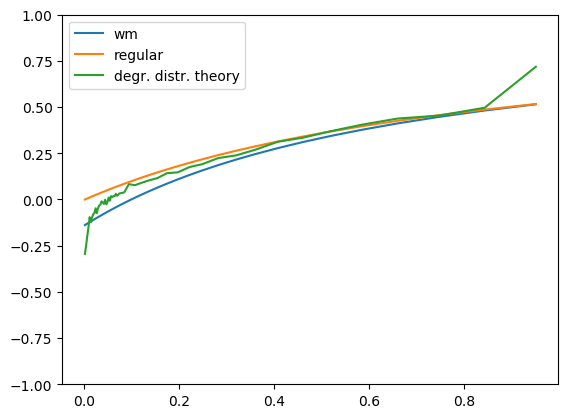

(-1,1)

In [31]:
using Dierckx
interpolation_order = 1
spl = Spline1D(n_range/N,s_range,k=interpolation_order,bc="extrapolate")
s_fn(x) = evaluate(spl,x)
# a_fn(x) = evaluate(Spline1D(n_range/N,a_range,k=interpolation_order,bc="extrapolate"),x)
# b_fn(x) = evaluate(Spline1D(n_range/N,N*b_range,k=interpolation_order,bc="extrapolate"),x)
# plot(y_range,alpha*y_range-beta,label="wm")
plot(y_range,(alpha*y_range-beta)./(2 + alpha*y_range + beta),label="wm")
plot(y_range,get_s_eff_exact(y_range,alpha,beta,k,N)./(2 +get_s_eff_exact(y_range,alpha,beta,k,N) + 2*beta) ,label="regular")
plot(y_range,s_fn(y_range)/2,label="degr. distr. theory")
# plot(y_range,s_fn1(y_range)/2,label="theory")
# plot(y_range,s_range,alpha=0.2)
legend(loc="best")
ylim(-1,1)

In [36]:
num_trials_wm = 10000
@time yy1,pp1,y_k_vec = get_p_reach_well_mixed_by_degree_simulation(N,alpha,beta,p_k,p_k_neighbor,num_trials_wm,true);

  0.364061 seconds (1.69 M allocations: 295.147 MB, 25.19% gc time)


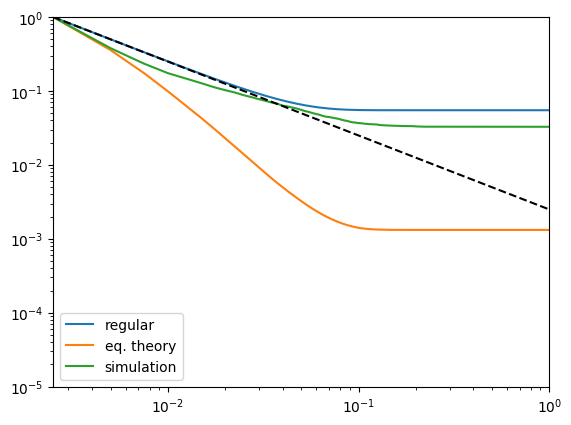

(0.0025,1.0)

In [38]:
yy = collect(1/N:1/N:1)        
im_reg = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,mean_k,N) , x -> 1 + beta);
im_wm = InfectionModel(x -> 1 + alpha*x, x -> 1 + beta);
pp_wm = P_reach_fast(im_wm,N,1.0/N,yy,true)
pp_reg = P_reach_fast(im_reg,N,1.0/N,yy,true)
pp_test = P_reach_raw_fast(x -> N*s_fn(x)/2,N,1.0/N,yy)
# pp_test = P_reach_raw_fast(x -> N*get_s_eff_exact(x,alpha,beta,mean_k,N)/(2 + get_s_eff_exact(x,alpha,beta,mean_k,N)+2*beta),N,1.0/N,yy)
# pp_test = P_reach_raw_fast(x -> N*(alpha*x - beta)/(2 +alpha*x+beta),N,1.0/N,yy)
# pp_test = P_reach_raw_fast(a_fn,x -> 1/N*b_fn(x),N,1.0/N,yy)

# loglog(yy,pp_wm)
loglog(yy,pp_reg,label="regular")
loglog(yy,pp_test,label="eq. theory")
loglog(yy1,pp1,label="simulation")
loglog(yy,1./(N*yy),"--k")
legend(loc="lower left")
ylim([1e-5,1])
xlim([1/N,1])

In [104]:

s_pre,s_post = get_s_mc(1,N,mean_k,z_k,beta,1000)

(-0.6164279674464951,0.013101371764774076)

In [59]:
beta = 0.01
y_0 = 1/N
a_vec =  [get_a(_,mean_k,y_0) for _ in 1:N-1]
b_vec =  [get_b(_,mean_k,y_0) for _ in 1:N-1]
a_mean = dot(a_vec,z_k)
b_mean = dot(b_vec,z_k)

2*a_mean/(N*b_mean)

-0.00994811852969141

1.0

In [56]:
beta = 0.01
y_0 = 1/N
s_k_tilde_vec = [get_s(_,mean_k,y_0) for _ in 1:N-1]
s_mean = dot(s_k_tilde_vec,z_k)
s_ideal = -beta
s_mean, s_ideal

(-0.6015593853177895,-0.01)

In [58]:
s_k_tilde_vec

399-element Array{Float64,1}:
 -1.68029  
 -1.4078   
 -1.17278  
 -0.968    
 -0.787977 
 -0.628478 
 -0.486182 
 -0.358448 
 -0.24315  
 -0.138555 
 -0.0432403
  0.0439776
  0.124088 
  ⋮        
  1.89429  
  1.89458  
  1.89487  
  1.89516  
  1.89544  
  1.89573  
  1.89601  
  1.89629  
  1.89657  
  1.89685  
  1.89712  
  1.8974   

In [21]:
kvec = collect(1:N-1)
alpha_curr = 0*alpha
beta_curr = 0*beta

p_live = dot(p_k_neighbor,1./kvec.*(1 + alpha_curr./kvec))#(1 + alpha/k)
p_die = (1 + beta_curr)

kbar = dot(p_k,kvec)
println(kbar*p_live/(kbar*p_live + p_die))
println(dot(p_k,kvec.*p_live./(kvec.*p_live + p_die)))
println(mean_k*p_live/(mean_k*p_live + p_die))

0.499926000484611
0.36286859065226923
0.499926000484611


In [541]:
dot(p_k,1./kvec),1./dot(p_k,kvec)

(0.20976326076381527,0.07717781142685594)

In [536]:
dot(p_k,kvec)

12.957091960915921

In [57]:
function s_test(x)
    if x < 2/N
        return -0.6
    else
        return 0.0
    end
end
yy = collect(1/N:1/N:1)        
im_test = InfectionModel(x -> 1 + beta + s_test(x) , x -> 1 + beta);
pp_test = P_reach_fast(im_test,N,1.0/N,yy,true)

400-element Array{Float64,1}:
 1.0        
 0.30238    
 0.150648   
 0.100124   
 0.0749785  
 0.0599278  
 0.0499094  
 0.0427608  
 0.0374035  
 0.0332391  
 0.0299091  
 0.0271856  
 0.0249167  
 ⋮          
 0.000769482
 0.000767504
 0.000765536
 0.000763578
 0.00076163 
 0.000759692
 0.000757764
 0.000755845
 0.000753936
 0.000752037
 0.000750148
 0.000748267

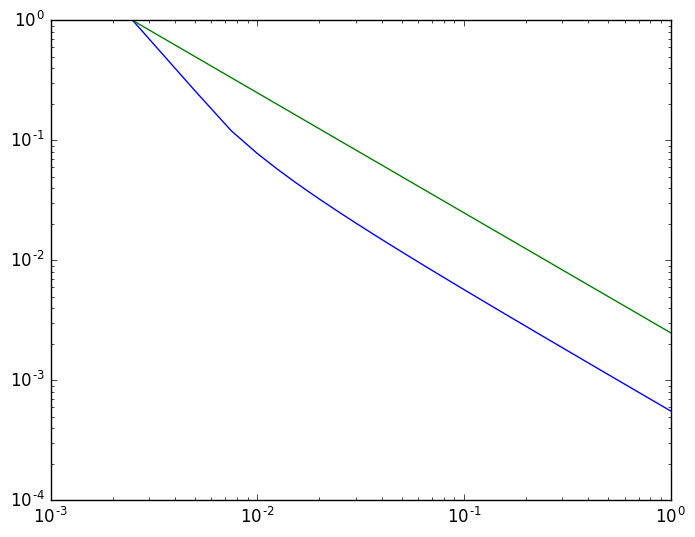

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32e44a950>

In [26]:
loglog(yy,pp_test)
loglog(yy,1./(N*yy))

# using JLD

## Testing Joint Degree Distribution

In [40]:
function rerandomize_edges(G,num_rewire=10)
    rewired = 0
    while rewired < num_rewire 
        curr_edges = collect(edges(G))
        rand_indices = rand(1:length(curr_edges),2)
        edge1 = curr_edges[rand_indices[1]]
        edge2 = curr_edges[rand_indices[2]]
        if valid_edge_swap(G,edge1,edge2)
            e1,e2 = swap_edges(edge1,edge2)
            rem_edge!(G,edge1)
            rem_edge!(G,edge2)
            add_edge!(G,e1)
            add_edge!(G,e2)
            rewired += 1
        end
    end
    println("rewired: $(rewired)")
end

function swap_edges(e1,e2)
    e3 = Pair(e1[1],e2[2])
    e4 = Pair(e2[1],e1[2])
    return e3,e4
end

function valid_edge_swap(G,e1,e2)
    if ~(degree(G,e1[1]) == degree(G,e2[1]) && degree(G,e1[2]) == degree(G,e2[2]))
        return false
    end
    if e1[1] == e2[1] || e1[2] == e2[2] return false end
    if e1[1] == e2[2] || e1[2] == e2[1] return false end
    e3,e4 = swap_edges(e1,e2)
    assert((e3[1] != e3[2]) && (e4[1] != e4[2]))
    if has_edge(G,e3) || has_edge(G,e4) return false end
    
    return true
end

valid_edge_swap (generic function with 1 method)

In [48]:
N = 2000
k_range = get_k_range(N)
k = 10
sigma_k = 30
min_degree =3

# degr_distr = get_p_k_gamma(sigma_k,k,min_degree)
# distr_fn = () -> graph_from_gamma_distribution(N,k,sigma_k,min_degree)

tdp = compute_two_degree_params(k,sigma_k)
degr_distr = get_p_k_two_degree(tdp)
G = graph_from_two_degree_distribution(N,k,sigma_k)
println(mean(local_clustering_coefficient(G)))
# @time rerandomize_edges(G,1*length(edges(G)))
# println(mean(local_clustering_coefficient(G)))
distr_fn = () -> G# graph_from_two_degree_distribution(N,k,sigma_k)


p_k,p_k_neighbor,mean_k = get_p_k_as_vec(degr_distr,N);



0.6917212490876864


In [49]:
@time p_k_exp,p_k_n_exp = create_p_k_p_k_neighbor_from_graph_fn(distr_fn,10)
p_k_n_ave_exp = p_k_exp'*p_k_n_exp

  0.552215 seconds (330.24 k allocations: 75.125 MB, 4.21% gc time)


1×1999 Array{Float64,2}:
 0.0  0.0  0.109833  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [223]:
data_dir_path = "../../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readstring(`ls $data_dir_path`));
path = data_dir_path*filenames[end-3]
params,yyg,ppg,epidemic_params,k,graph_information,graph_type,runs,num_trials = load_p_reach_data(path);

LoadError: UndefVarError: load_p_reach_data not defined

In [50]:
n_trials = 100
ks = find(p_k .> 0)
ls = length(ks)
# ks_map = Dict(ks[i] => i for i in 1:length(ks))
neighbor_degrees = [zeros(ks_) for ks_ in ks]
mean_neighbor_degree = 1.0*zeros(length(ks),length(ks))
var_neighbor_degree = 1.0*zeros(length(ks),length(ks))
covar_neighbor_degree = 1.0*zeros(length(ks),length(ks))
count_mat = 1.0*zeros(length(ks),length(ks))
tot_trials = N*n_trials

@time for i in 1:n_trials
    G = distr_fn()
    for v in vertices(G)
        k_curr = degree(G,v)
        neighbor_degrees = degree(G,neighbors(G,v))
        for k_possible in ks
            curr_count = counts(neighbor_degrees,k_possible:k_possible)[1]
            other_count = length(neighbor_degrees) - curr_count
            mean_neighbor_degree[ks_map[k_curr],ks_map[k_possible]] += curr_count 
            var_neighbor_degree[ks_map[k_curr],ks_map[k_possible]] += curr_count^2 
            covar_neighbor_degree[ks_map[k_curr],ks_map[k_possible]] += curr_count*other_count
            count_mat[ks_map[k_curr],ks_map[k_possible]] += 1
        end
    end
end
    
mean_neighbor_degree ./= count_mat 
var_neighbor_degree ./= count_mat 
covar_neighbor_degree ./= count_mat 


LoadError: UndefVarError: ks_map not defined

In [51]:

mean_neighbor_degree_th = 1.0*zeros(length(ks),length(ks))
var_neighbor_degree_th = 1.0*zeros(length(ks),length(ks))
covar_neighbor_degree_th = 1.0*zeros(length(ks),length(ks))

for k_curr in ks
    delta_k = 1# - k_curr/(N)
    for k_possible in ks
        pkn_curr = p_k_n_exp[k_curr,k_possible]
        pkn_other = 1 - pkn_curr 
        mean_neighbor_degree_th[ks_map[k_curr],ks_map[k_possible]] =
            k_curr*pkn_curr
        var_neighbor_degree_th[ks_map[k_curr],ks_map[k_possible]] =
        (k_curr*pkn_curr)^2 +k_curr*pkn_curr*(1-pkn_curr)*delta_k
        covar_neighbor_degree_th[ks_map[k_curr],ks_map[k_possible]] =
        k_curr^2*pkn_curr*pkn_other - k_curr*pkn_curr*pkn_other*delta_k
    end
end


LoadError: UndefVarError: ks_map not defined

In [52]:
# mean_neighbor_degree,mean_neighbor_degree_th
var_neighbor_degree,var_neighbor_degree_th
# covar_neighbor_degree,covar_neighbor_degree_th

(
[0.0 0.0; 0.0 0.0],

[0.0 0.0; 0.0 0.0])

In [53]:
function fractional_occurences(list,item)
    return sum(list .== item)/length(list)
end

nonzero_ks = find(p_k .> 0)

ks_to_condition = k_range
ks_to_print = [3,5]
ks_to_condition = [3]


for k_curr in nonzero_ks
    if k_curr in ks_to_print
        println()
        println("P($(k_curr))")
        println("th: $(p_k[k_curr])")
        println("ex: $(fractional_occurences(all_self_degrees,k_curr))")
        println()
        println("P($(k_curr) | any k)")
        println("th: $(p_k_neighbor[k_curr])")
        println("ex: $(fractional_occurences(all_neighbor_degrees,k_curr))")
    end
end
for k_curr in nonzero_ks
    for k_curr_prime in nonzero_ks
        if k_curr in ks_to_condition
            if fractional_occurences(neighbor_degrees[k_curr],k_curr_prime) > 0
                println()
                println("P($(k_curr_prime) | $(k_curr))")
                println("conditioned on k = $(k_curr)")
                println("th: $(p_k_neighbor[k_curr_prime])")
                println("ex: $(fractional_occurences(neighbor_degrees[k_curr],k_curr_prime))")
            end
        end
    end
end


P(3)
th: 0.9485294117647058


LoadError: UndefVarError: all_self_degrees not defined

In [73]:
count_mat[:,1] ./ p_k_exp[ks]

2-element Array{Float64,1}:
 39865.7
 40269.1

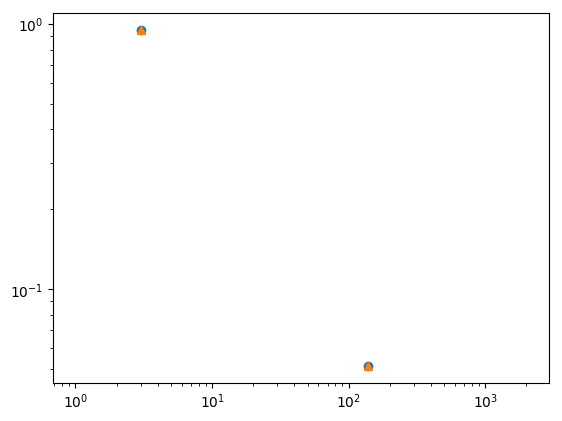

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x322ef1790>

In [54]:
# ks = all_self_degrees
# bins = logspace(log10(minimum(ks))-2,log10(maximum(ks))+1,50)
# bins = collect(1:N)
# PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.5,log=true);
plot(k_range,[p_k[_] for _ in k_range],"o",linewidth=1)
plot(k_range,[p_k_exp[_] for _ in k_range],"^",linewidth=1)
loglog([],[])
# xscale("log")
# xlim([0,maximum(ks)+5])
# ylim([1/(2*n_trials*N),1])


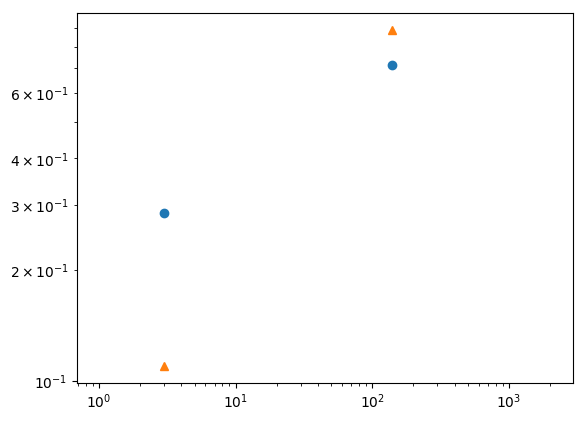

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328c7f050>

In [55]:
# ks = all_neighbor_degrees
# bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),30)
# bins = collect(1:N)
# PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.5,log=true);
plot(k_range,[p_k_neighbor[_] for _ in k_range],linewidth=1,"o")
plot(k_range,[p_k_n_ave_exp[_] for _ in k_range],linewidth=1,"^")
loglog([],[])
# xscale("log")
# xlim([0,maximum(ks)+5])
# ylim([1/(2*n_trials*N),1])


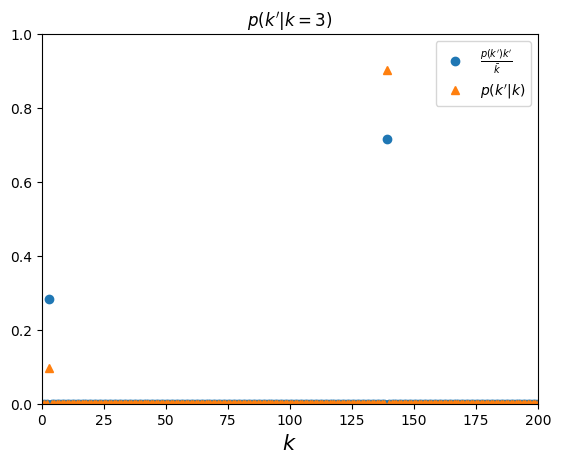

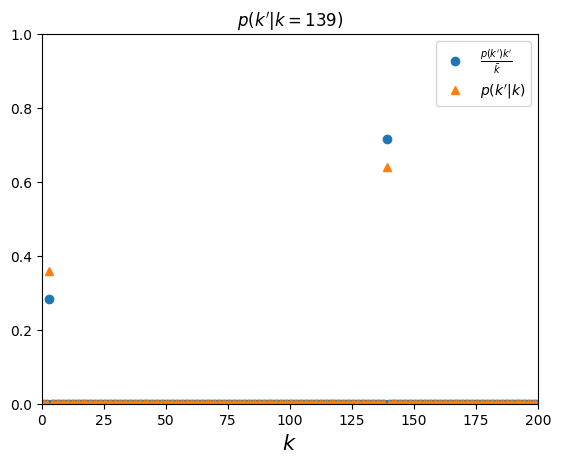

In [66]:

condition_degrees = [3,139]
for condition_degree in condition_degrees
    figure()
    title(latexstring("\$p(k'|k=$(condition_degree))\$"))
#     ks = neighbor_degrees[condition_degree]
#     bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),40)
#     bins = collect(1:N)
#     PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.4,log=true);
    plot(k_range,[p_k_neighbor[_] for _ in k_range],"o",label=L"\frac{p(k') k'}{\bar{k}}")
    plot(k_range,[p_k_n_exp[condition_degree,_] for _ in k_range],"^",label=L"p(k'|k)")
#     plot(k_range,[p_k_n_ave_exp[_] for _ in k_range],label=L"P_{neighbor}(k)")
    #     loglog([],[])
#     xscale("log")
    xlabel(L"k",size=15)
    legend(loc="best")
    xlim([0,200])
    ylim([0.001,1])
#     xlim([0,maximum(ks)+5])
#     xlim([0,20])#maximum(ks)+5])
#     ylim([1/(2*n_trials*N),1])
end


In [57]:
find(p_k .> 0)

2-element Array{Int64,1}:
   3
 139

## Ideas

- The solutions for $y_k$ are expected: for lower degree, we expect higher infection rates.
- This clearly does not capture the behavior of the simulations
- Maybe we are missing the fact that each run starts with _a specific node of degree k_. Maybe we can have a theory conditioning on the starting node. Then we average over starters.
    - could test this as follows: take a graph with a bimodal degree distribution (to give k and sigma_k). Then start with 2/N nodes and place them on the two types of nodes (so we achieve approximately equal starting point density).

### How can any $s$ give rise to a non-neutral $P_{reach}$ for low $y$?

In [311]:
using JLD
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readall(`ls $data_dir_path`));
path = data_dir_path*filenames[end-1]
d = JLD.load(path)
params = d["params"]
compact = params["compact"]
runs = d["runs"]
sizes = runs.sizes
pvals = runs.p_reach
yvals = runs.y_reach


interpolation_order = 3
pvals_fn(x) = evaluate(Spline1D(yvals,pvals,k=interpolation_order,bc="extrapolate"),x)

pvals_fn (generic function with 1 method)

In [320]:
yyy = collect(1/N:1/(10*N):1)
vec = (1./pvals_fn(yyy))
h = diff(yyy)[1]
up = vec[3:end]
mid = vec[2:end-1]
down = vec[1:end-2]

dpdy = (up - down)/(2*h)
d2pd2y = (up + down - 2*mid)/(h^2)
dpdy,d2pd2y

([5016.88,4348.0,3455.08,2784.68,2700.22,3040.07,3421.92,3713.0,3841.23,3741.96  …  4.60976e5,4.9268e5,5.27771e5,5.66751e5,610216.0,6.58883e5,7.13616e5,7.75467e5,8.45728e5,925996.0],[-4.5658e6,-8.81191e6,-9.04648e6,-4.36151e6,2.67234e6,4.12476e6,3.51226e6,2.30919e6,2.55461e5,-2.2409e6  …  3.01238e8,3.32828e8,3.68996e8,4.10601e8,4.58705e8,5.14629e8,5.80028e8,6.56999e8,7.48219e8,8.57145e8])

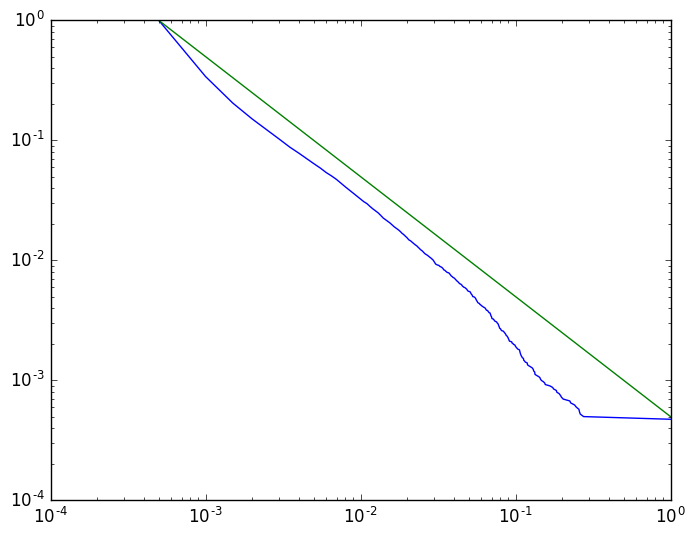

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3337135d0>

In [321]:
loglog(yvals,pvals_fn(yvals))
loglog(yvals,1./(2000*yvals))

In [19]:
num_trials = 4000
N = 100
in_parallel = true


c_r = 0.3
N = 400
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
fixation_threshold = 1.0

k =10
sigma_k = 10

TWO_DEGREE = 1
GAMMA = 2

graph_type = TWO_DEGREE 
verbose = false

if verbose println(N, ' ' ,alpha, ' ',beta) end

###Set to true if we want by-node information on infecteds (much more data!)
carry_by_node_information = false
graph_model = true
in_parallel = true

# G = graph_from_two_degree_distribution(N,k,sigma_k)
graph_data = nothing
if graph_type == GAMMA
    graph_fn = () -> graph_from_gamma_distribution(N,k,sigma_k)
    graph_data = sigma_k
elseif graph_type == TWO_DEGREE
    graph_fn = () -> G#graph_from_two_degree_distribution(N,k,sigma_k)
    graph_data = sigma_k
end

graph_information = GraphInformation(graph_fn,G,carry_by_node_information,graph_data)

@time runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph(N,im_normal,graph_information,fixation_threshold),in_parallel);
yy,pp = get_p_reach(runs)




145.052746 seconds (2.67 G allocations: 39.988 GB, 3.16% gc time)


([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0  …  44.0,45.0,46.0,48.0,52.0,57.0,59.0,64.0,71.0,400.0],[1.0,0.40875,0.27675,0.20775,0.173,0.148,0.127,0.112,0.0995,0.0915  …  0.034,0.03375,0.03325,0.033,0.03275,0.0325,0.03225,0.032,0.03175,0.0315])

In [17]:
p_k_exp,p_k_neighbor_exp = create_p_k_p_k_neighbor_from_graph_fn(graph_fn,10)
num_trials_ = 100_000
hypergeometric = true
@time yy1,pp1,y_k_vec = get_p_reach_well_mixed_by_degree_simulation(N,alpha,beta,p_k_exp,p_k_neighbor_exp,num_trials_,hypergeometric)


  2.490026 seconds (20.23 M allocations: 2.440 GB, 14.66% gc time)


([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.15,0.155,0.1575,0.16,0.1625,0.17,0.175,0.1825,0.185,1.0],[1.0,0.41687,0.27485,0.21537,0.17904,0.15381,0.13594,0.12172,0.11035,0.10116  …  0.0421,0.04208,0.04203,0.04197,0.04195,0.04194,0.04193,0.04192,0.04191,0.0419],)

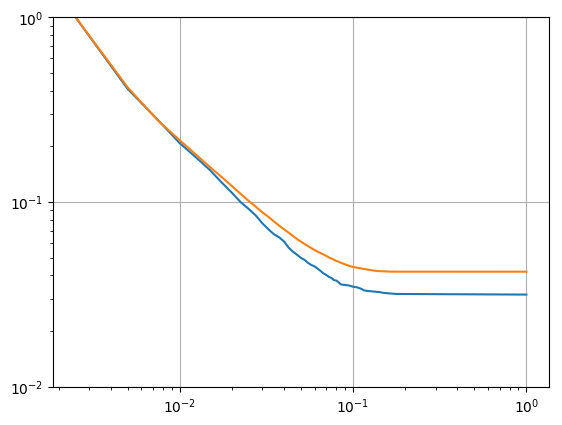

In [20]:
loglog(yy/N,pp)
loglog(yy1,pp1)
ylim([1e-2,1])
grid()

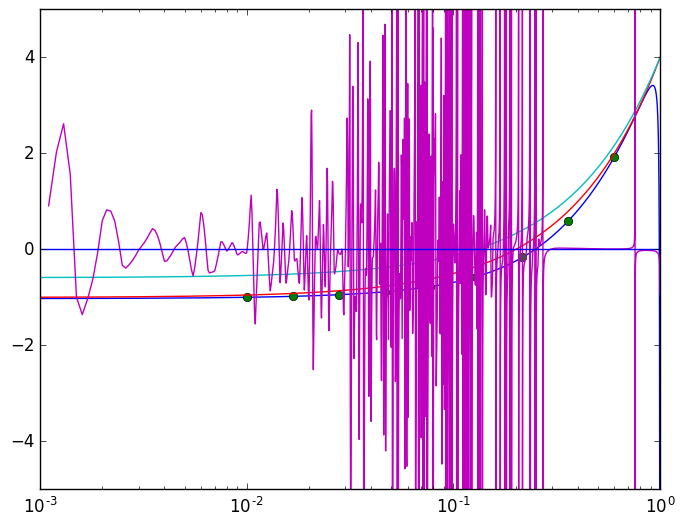

(-5,5)

In [322]:
semilogx(yy,s_fn(yy)./(yy.*(1 - yy)))
plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)),"o")
plot(yy,alpha*yy - beta)
plot(yy,get_s_eff_exact(yy,alpha,beta,k,N))
plot(yyy[2:end-1],-1/N*d2pd2y./dpdy)
axhline(0)
ylim([-5,5])